# Facility sampling

The purpose of this notebook is to demonstrate weighted and rule-based facility sampling methods.

PAM offers a facility sampler, which can be called wtih `pam.samplers.facility.FacilitySampler(facilities, zones, ...)`,
where `facilities` and `zones` are geodataframes containing the available activity locations and the model zoning system respectively.

The `weight_on` option of the sampler allows to specify a column of the facilities dataset to be used for weighting the candidate locations (for example, by floorspace). *nb: weighted sampling here samples with replacement, while the default (unweighted) option iterates across a shuffled list of the candidate locations instead)*.

By providing a `max_walk` argument, we constrain activity locations accessed with PT modes (named as `bus`, `rail`, or `pt`) to be located within that distance (crow's fly) from a PT stop. The distance of each facility from a PT stop should be provided in the `facilities` dataset (under the `transit` field).


We can sample facility locations for a PAM population, with the `population.sample_locs(sampler)` method, where sampler is an instance of `pam.samplers.facility.FacilitySampler`. Depending whether we `weight_on` option was activated for the sampler, it will undertake simple or weighted sampling.

To accommodate more complex sampling techniques, we have introduced `population.sample_locs_complex(sampler)`. This method passes additional information to the sampler, such as the duration and mode of arriving trip and the previous activity location. The sampler then applies some extra rules:
* distance-weighted sampling: for the given trip duration, try to adjust candidate facility weights so that their distance from the previous location is consistent with the trip duration and mode speed. The weights are adjusted as $ adjusted\_weight_j =  \frac{weight_j}{expected\_distance_{ij}^2}$, where $ expected\_distance_{ij} = \lvert{distance_{ij} - (duration * speed)}\rvert $. The mode speeds (expressed in euclidean distance terms) are defined in `pam.variables.EXPECTED_EUCLIDEAN_SPEEDS` dictionary.
* distance from PT stop rule: if the mode is PT and `max_walk` has been provided, contrain the options within the specified radius from a stop



**Caveats**
* The complex sampler is experimental at this stage and should be used with care.
* All distance units are calculated as euclidean distances. Expected speeds should also be expressed in euclidean measures. Distance calculations assume a linear-unit (meters) coordinate system. In the future, we should try to integrate model skims in the calculation.
* Distance-based weighting can be used to help better align sampled durations with locations. However, it only looks one trip ahead, and it is likely to be inconsistent for the last trip (ie the path doesn't necessarily "close" well).

In [1]:
import logging

import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon

import pam
from pam.activity import Activity, Leg
from pam.core import Household, Person, Population
from pam.samplers import facility
from pam.utils import minutes_to_datetime

## Generate Data

### Geography

Create a dummy dataset of facilities and their locations:

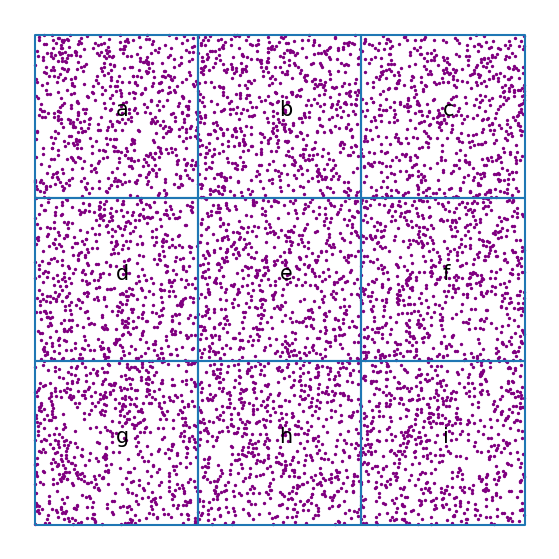

In [2]:
# create random spatial data

# create zones
length = 10000  # square length in meters
polygon_list = []
zone_list = ["a", "b", "c", "d", "e", "f", "g", "h", "i"]
activities_list = ["home", "work", "other", "shop", "escort", "education"]

for y in [2 * length, length, 0]:
    for x in [0, length, 2 * length]:
        polygon_list.append(
            Polygon([[x, y], [x + length, y], [x + length, y + length], [x, y + length], [x, y]])
        )

zones = gp.GeoDataFrame(geometry=polygon_list)
zones["zone"] = zone_list
zones = zones.set_index("zone")

# create facilities
point_list = []
for activity in activities_list:
    for _i in range(1000):
        point = Point(np.random.rand() * 3 * length, np.random.rand() * 3 * length)
        point_list.append(
            {
                "activity": activity,
                "floors": np.random.randint(1, 4),
                "units": np.random.randint(1, 20),
                "area": np.random.randint(1, 100),
                "transit": np.random.randint(1, 10000),
                "geometry": point,
            }
        )

facilities = gp.GeoDataFrame(point_list)
facilities = gp.sjoin(facilities, zones.reset_index()).drop(columns="index_right")


# plot
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
zones.boundary.plot(ax=ax)
facilities.plot(ax=ax, markersize=2, color="purple")
for zone, centroid in zip(zones.index, zones.centroid):
    ax.annotate(zone, xy=(centroid.x, centroid.y), size=15)
ax.axis("off")
plt.show()

In [3]:
# facilities dataset:
facilities.head()

,activity,floors,units,area,transit,geometry,zone
0,home,3,12,25,3487,POINT (10757.796 20531.955),b
5,home,3,18,66,9594,POINT (11554.279 22839.089),b
10,home,2,10,38,1468,POINT (18588.552 25925.233),b
14,home,3,17,29,4729,POINT (17518.410 21357.769),b
41,home,3,11,98,4235,POINT (12100.069 23832.929),b


## Population

### Distance-based sampling

Let's assume a 30-min walking commute trip from home.

The expected straight-line speed for the trip is:

In [4]:
print(
    "The expected straight-line speed for the trip is: {} kph".format(
        pam.variables.EXPECTED_EUCLIDEAN_SPEEDS["walk"]
    )
)

The expected straight-line speed for the trip is: 1.3888888888888888 kph


Therefore, we expect the sampler to pick a workplace location approx 5 * 0.5=2.5km from home.

In [5]:
p1 = Person("p1", attributes={"age": 40})
p1.add(
    Activity(
        seq=1,
        act="home",
        area="a",
        start_time=minutes_to_datetime(0),
        end_time=minutes_to_datetime(60),
    )
)
p1.add(
    Leg(
        seq=1,
        mode="walk",
        start_area="a",
        end_area="a",
        start_time=minutes_to_datetime(60),
        end_time=minutes_to_datetime(90),
    )
)
p1.add(
    Activity(
        seq=2,
        act="work",
        area="a",
        start_time=minutes_to_datetime(90),
        end_time=minutes_to_datetime(120),
    )
)

hh1 = Household(0)
hh1.add(p1)

population = Population()
population.add(hh1)

In [6]:
# supress logger warnings

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [7]:
def test_sampler_distance(
    population, sampler, n_iterations=20, complex_sampler=False, title=None
):  # increase this
    distance_commute = []

    for _i in range(n_iterations):
        if complex_sampler:
            population.sample_locs_complex(sampler)
        else:
            population.sample_locs(sampler)
        distance_commute.append(population.trips_df()["euclidean_distance"][0])

    pd.Series(distance_commute).hist(bins=20)
    if title is not None:
        plt.title(title)
    plt.xlabel("distance")
    plt.ylabel("frequency")
    plt.show()

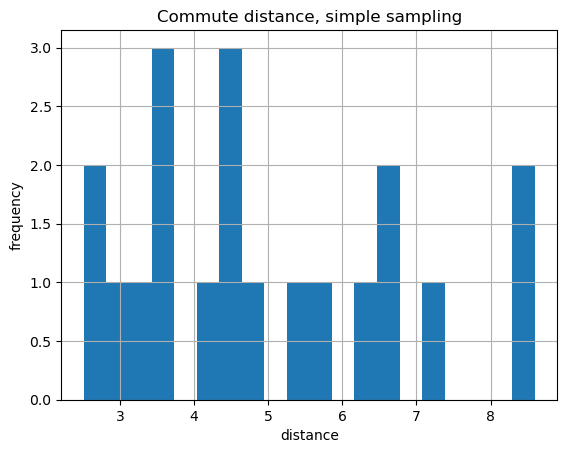

In [8]:
# simple sampling


facility_sampler_nonweighted = facility.FacilitySampler(
    facilities=facilities, zones=zones, build_xml=True, fail=False, random_default=True
)

test_sampler_distance(
    population,
    facility_sampler_nonweighted,
    complex_sampler=False,
    title="Commute distance, simple sampling",
)

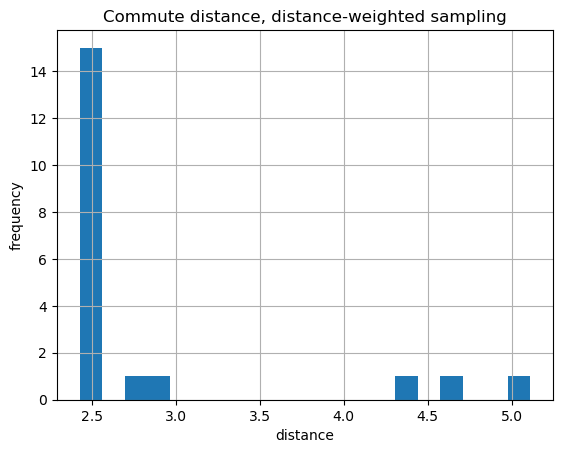

In [9]:
# distance-weighted sampling

distance_commute_weighted = []

facility_sampler_weighted = facility.FacilitySampler(
    facilities=facilities.assign(weight1=1),
    zones=zones,
    build_xml=True,
    fail=False,
    random_default=True,
    weight_on="weight1",
)

test_sampler_distance(
    population,
    facility_sampler_weighted,
    complex_sampler=True,
    title="Commute distance, distance-weighted sampling",
)

Similar experiment to above, with a 30-min car trip from zone a to zone b:

In [10]:
print(
    "The expected straight-line speed for the trip is: {} kph".format(
        pam.variables.EXPECTED_EUCLIDEAN_SPEEDS["car"]
    )
)

The expected straight-line speed for the trip is: 5.555555555555555 kph


--> we should expect higher sampling of locations in a radius closer to 20 * 0.5= 10km.

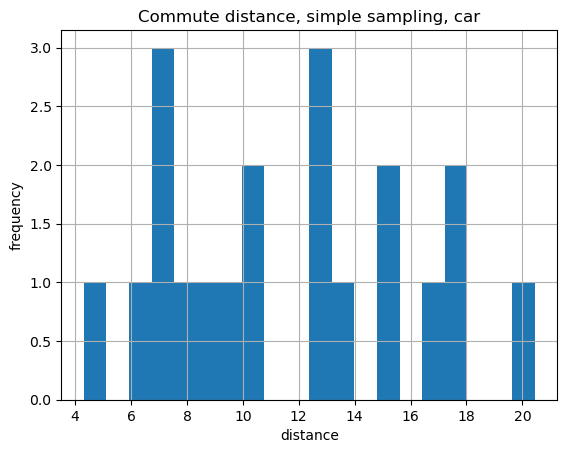

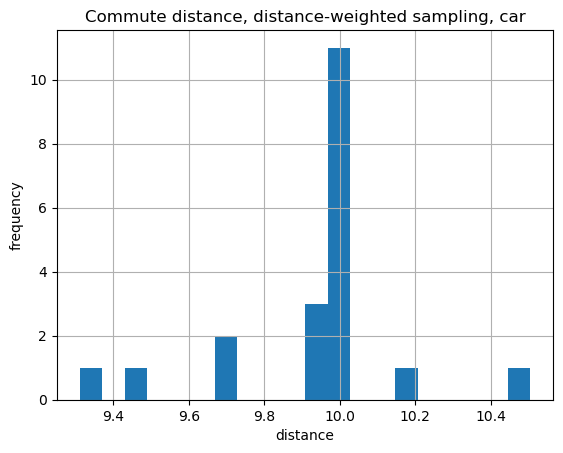

In [11]:
p2 = Person("p2", attributes={"age": 40})
p2.add(
    Activity(
        seq=1,
        act="home",
        area="a",
        start_time=minutes_to_datetime(0),
        end_time=minutes_to_datetime(60),
    )
)
p2.add(
    Leg(
        seq=1,
        mode="car",
        start_area="a",
        end_area="b",
        start_time=minutes_to_datetime(60),
        end_time=minutes_to_datetime(90),
    )
)
p2.add(
    Activity(
        seq=2,
        act="work",
        area="b",
        start_time=minutes_to_datetime(90),
        end_time=minutes_to_datetime(120),
    )
)

hh2 = Household(0)
hh2.add(p2)

population2 = Population()
population2.add(hh2)

test_sampler_distance(
    population2,
    facility_sampler_nonweighted,
    complex_sampler=False,
    title="Commute distance, simple sampling, car",
)
test_sampler_distance(
    population2,
    facility_sampler_weighted,
    complex_sampler=True,
    title="Commute distance, distance-weighted sampling, car",
)

As expected, between long-distance alternatives (ie from zone a to zone i), deviation from expected distance makes less difference (but does slightly shift the distribution towards the correct direction).

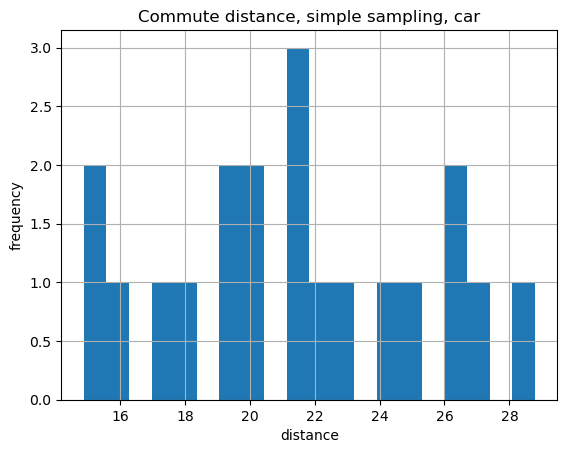

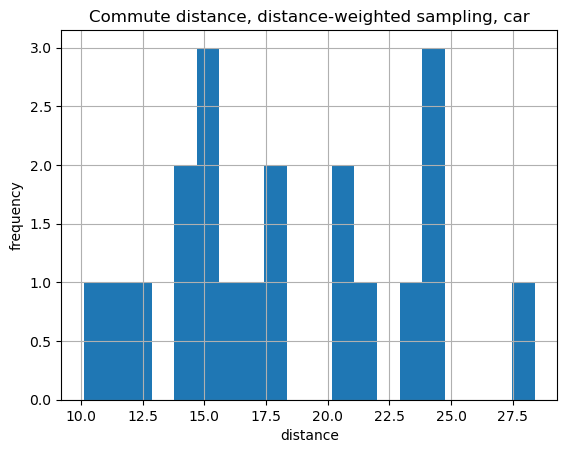

In [12]:
p3 = Person("p3", attributes={"age": 40})
p3.add(
    Activity(
        seq=1,
        act="home",
        area="a",
        start_time=minutes_to_datetime(0),
        end_time=minutes_to_datetime(60),
    )
)
p3.add(
    Leg(
        seq=1,
        mode="car",
        start_area="a",
        end_area="c",
        start_time=minutes_to_datetime(60),
        end_time=minutes_to_datetime(90),
    )
)
p3.add(
    Activity(
        seq=2,
        act="work",
        area="c",
        start_time=minutes_to_datetime(90),
        end_time=minutes_to_datetime(120),
    )
)

hh3 = Household(0)
hh3.add(p3)

population3 = Population()
population3.add(hh3)

test_sampler_distance(
    population3,
    facility_sampler_nonweighted,
    complex_sampler=False,
    title="Commute distance, simple sampling, car",
)
test_sampler_distance(
    population3,
    facility_sampler_weighted,
    complex_sampler=True,
    title="Commute distance, distance-weighted sampling, car",
)